Exploratory Data Analysis of Sample Dataset

In [ ]:
sampling_rate = 1000
start_baseline_time = 0.0
end_baseline_time = 2.0
start_evoked_time = 2.0
end_evoked_time = 4.0

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery


In [13]:
from data_audit import print_audit_report, audit_lfp_dataset
from get_data import dataset_stats

dataset_stats_df = dataset_stats(bigquery.Client(project='neural-ds-fe73'))
sample_data = pd.read_parquet('sample_data.parquet')
report = audit_lfp_dataset(sample_data)
print_audit_report(report, dataset_stats_df)

/opt/anaconda3/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


LFP SAMPLE DATASET AUDIT REPORT

SAMPLE DATASET STATS
   Total trials: 5895
   Total sessions: 2
   WT sessions: 1
   FMR1 sessions: 1
   Mean trials/session: 2947.5
   Std trials/session: 2386.5
   Min trials/session: 1260
   Max trials/session: 4635
   # frequencies: 15
   # amplitudes: 5
   # freq-amp combos: 75

TRACE COUNT QUALITY
   Expected length: 5001
   Parsed traces: 5895 of 5895
   Min length: 5001
   Max length: 5001
   Mean length: 5001.0
   Std length: 0.0
   Mismatched lengths: 0
   Truncated traces: 0
   Parse errors: 0
   Unique lengths: [5001]

FULL DATASET STATS (BQ)
   Total trials: 77418
   Total sessions: 32
   WT sessions: 25
   FMR1 sessions: 7
   Mean trials/session: 2419.3
   Std trials/session: 1039.2
   Min trials/session: 1215
   Max trials/session: 4635
   # frequencies: 22
   # amplitudes: 5
   # freq-amp combos: 96

COMPARISON (SAMPLE vs FULL)
   Total trials: 5895 vs 77418 (7.6% of full)
   Total sessions: 2 vs 32 (6.2% of full)
   WT sessions: 1 vs 25

In [14]:
from preprocessing import process_trace_column
sample_data['trace'] = process_trace_column(sample_data['trace'])

Trace plots

In [15]:
# Configuration
FS = 1000  # Sampling frequency in Hz
STIMULUS_ONSET = 2.0  # Stimulus onset time in seconds
TRACE_LENGTH = 5001  # Expected trace length in samples

# Helper function to convert trace to numpy array
def parse_trace(trace):
    """Convert trace to numpy array, handling various formats."""
    if isinstance(trace, np.ndarray):
        return trace
    if isinstance(trace, list):
        return np.array(trace)
    if isinstance(trace, str):
        # Handle string representation of array
        return np.fromstring(trace.strip('[]'), sep=' ')
    return np.array(trace)

# Create time axis
time_axis = np.arange(TRACE_LENGTH) / FS  # Time in seconds


### 1. Raw Trace Plots: WT vs FMR1 Comparison
Compare example traces from each condition to visualize basic signal characteristics.


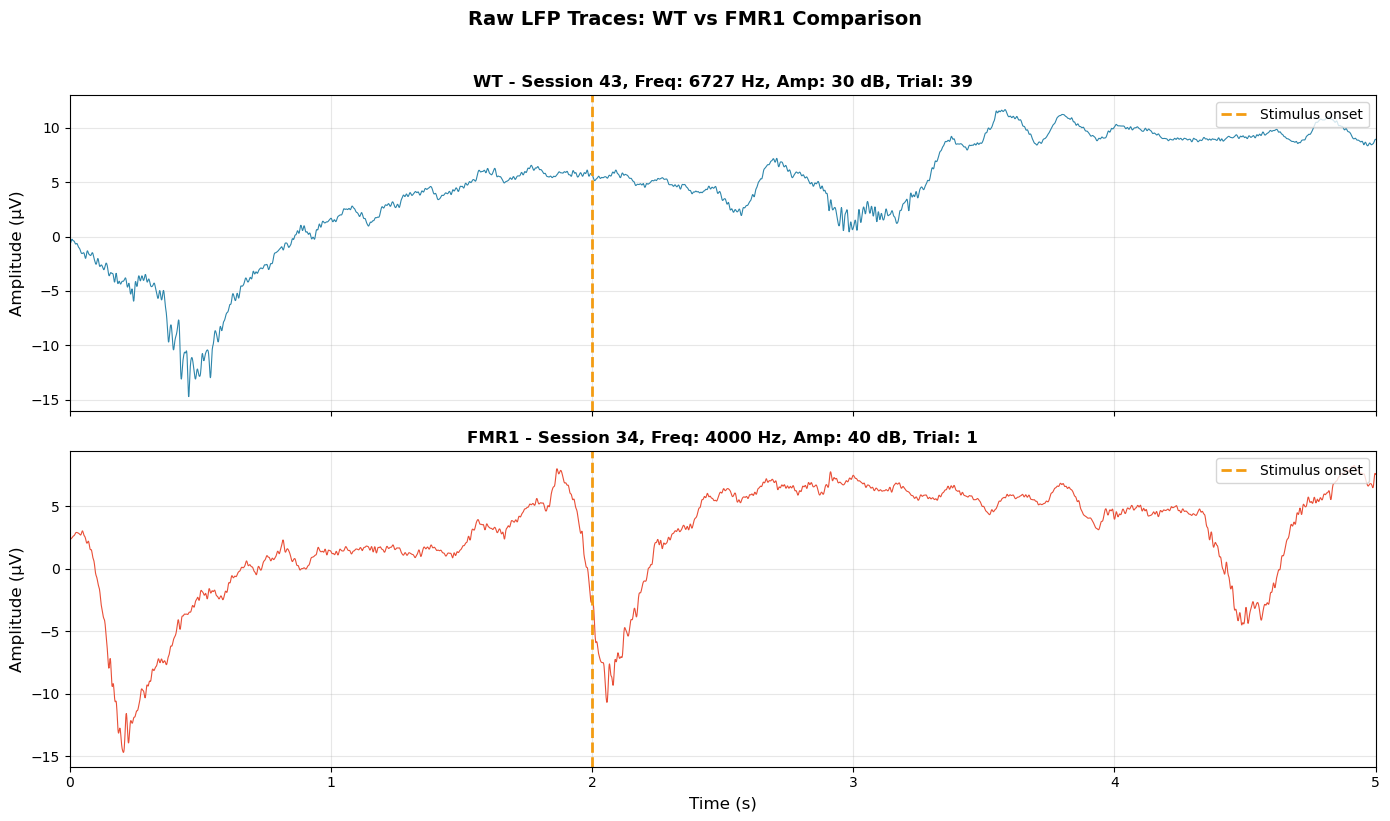

In [16]:
# Raw Trace Plots: WT vs FMR1 Comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for idx, condition in enumerate(['WT', 'FMR1']):
    ax = axes[idx]
    
    # Get first trial from this condition
    condition_data = sample_data[sample_data['condition'] == condition].iloc[0]
    trace = parse_trace(condition_data['trace'])
    
    # Plot trace
    ax.plot(time_axis, trace, linewidth=0.8, color='#2E86AB' if condition == 'WT' else '#E94F37')
    
    # Add stimulus onset marker
    ax.axvline(STIMULUS_ONSET, color='#F39C12', linestyle='--', linewidth=2, label='Stimulus onset')
    
    # Styling
    ax.set_ylabel('Amplitude (μV)', fontsize=12)
    ax.set_title(f'{condition} - Session {condition_data["session"]}, '
                 f'Freq: {condition_data["frequency"]} Hz, Amp: {condition_data["amplitude"]} dB, '
                 f'Trial: {condition_data["trial_num"]}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 5])

axes[1].set_xlabel('Time (s)', fontsize=12)
plt.suptitle('Raw LFP Traces: WT vs FMR1 Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 2. Overlay Plots: Trial-to-Trial Variability
Overlay multiple trials from the same session/stimulus to visualize within-session variability. This is key for understanding the hypothesis that FMR1 mice show higher trial-to-trial variability.


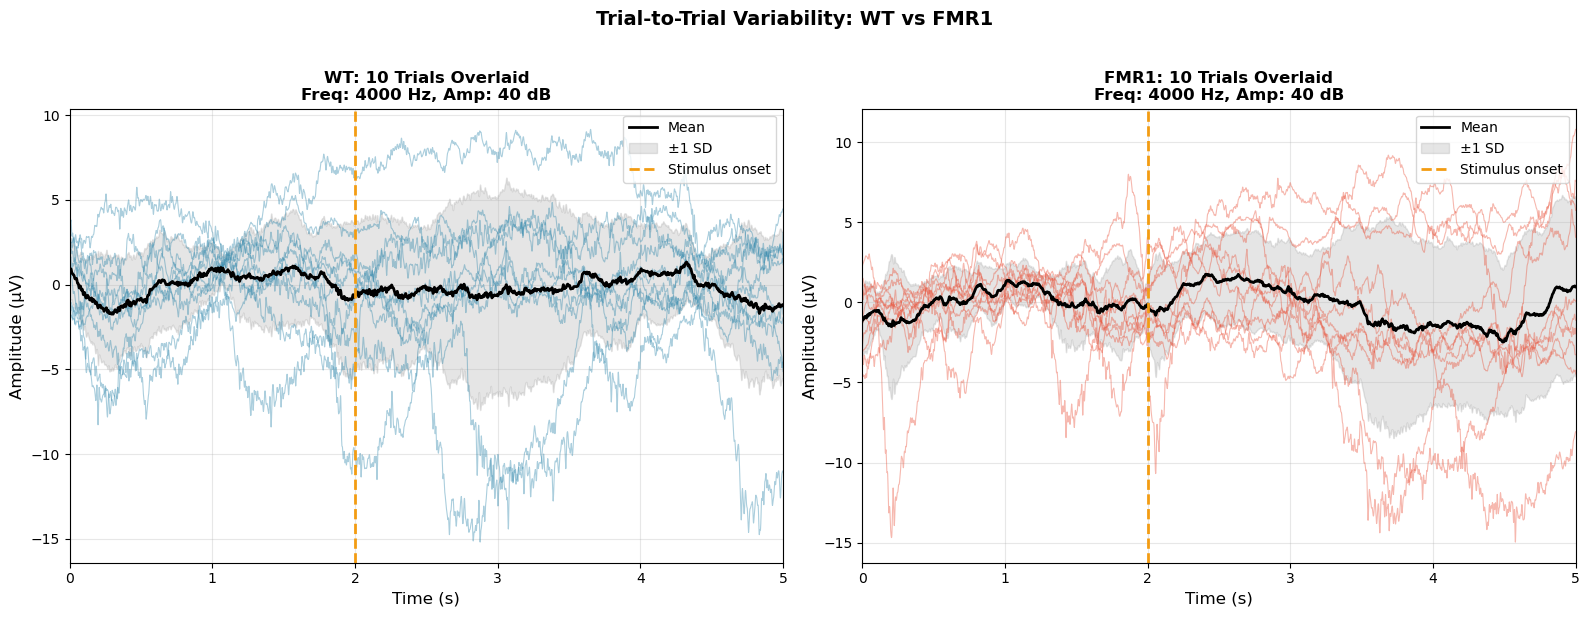


📊 Variability Statistics (Standard Deviation of Traces):
   WT: Mean SD across time = 3.5396
   FMR1: Mean SD across time = 3.3073


In [17]:
# Overlay Plots: Multiple trials from same session/stimulus
N_TRIALS_OVERLAY = 10  # Number of trials to overlay

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = {'WT': '#2E86AB', 'FMR1': '#E94F37'}

for idx, condition in enumerate(['WT', 'FMR1']):
    ax = axes[idx]
    
    # Get data for this condition
    condition_df = sample_data[sample_data['condition'] == condition]
    
    # Pick a common frequency/amplitude combination with enough trials
    freq_amp_counts = condition_df.groupby(['frequency', 'amplitude']).size()
    best_combo = freq_amp_counts.idxmax()
    
    # Filter to this stimulus condition
    subset = condition_df[
        (condition_df['frequency'] == best_combo[0]) & 
        (condition_df['amplitude'] == best_combo[1])
    ].head(N_TRIALS_OVERLAY)
    
    # Plot each trial with transparency
    for i, (_, row) in enumerate(subset.iterrows()):
        trace = parse_trace(row['trace'])
        alpha = 0.3 + (0.5 * i / N_TRIALS_OVERLAY)  # Gradient alpha
        ax.plot(time_axis, trace, linewidth=0.8, alpha=0.4, color=colors[condition])
    
    # Calculate and plot mean trace
    all_traces = np.array([parse_trace(row['trace']) for _, row in subset.iterrows()])
    mean_trace = all_traces.mean(axis=0)
    std_trace = all_traces.std(axis=0)
    
    ax.plot(time_axis, mean_trace, linewidth=2, color='black', label='Mean')
    ax.fill_between(time_axis, mean_trace - std_trace, mean_trace + std_trace, 
                    alpha=0.2, color='gray', label='±1 SD')
    
    # Stimulus onset marker
    ax.axvline(STIMULUS_ONSET, color='#F39C12', linestyle='--', linewidth=2, label='Stimulus onset')
    
    # Styling
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Amplitude (μV)', fontsize=12)
    ax.set_title(f'{condition}: {N_TRIALS_OVERLAY} Trials Overlaid\n'
                 f'Freq: {best_combo[0]} Hz, Amp: {best_combo[1]} dB', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 5])

plt.suptitle('Trial-to-Trial Variability: WT vs FMR1', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print variability statistics
print("\n📊 Variability Statistics (Standard Deviation of Traces):")
for condition in ['WT', 'FMR1']:
    condition_df = sample_data[sample_data['condition'] == condition]
    freq_amp_counts = condition_df.groupby(['frequency', 'amplitude']).size()
    best_combo = freq_amp_counts.idxmax()
    subset = condition_df[
        (condition_df['frequency'] == best_combo[0]) & 
        (condition_df['amplitude'] == best_combo[1])
    ].head(N_TRIALS_OVERLAY)
    
    all_traces = np.array([parse_trace(row['trace']) for _, row in subset.iterrows()])
    mean_std = all_traces.std(axis=0).mean()
    print(f"   {condition}: Mean SD across time = {mean_std:.4f}")


### 3. Event-Aligned Plots: Stimulus-Locked Response
Focus on the evoked response window around stimulus onset. This visualization shows the neural response time-locked to stimulus presentation.


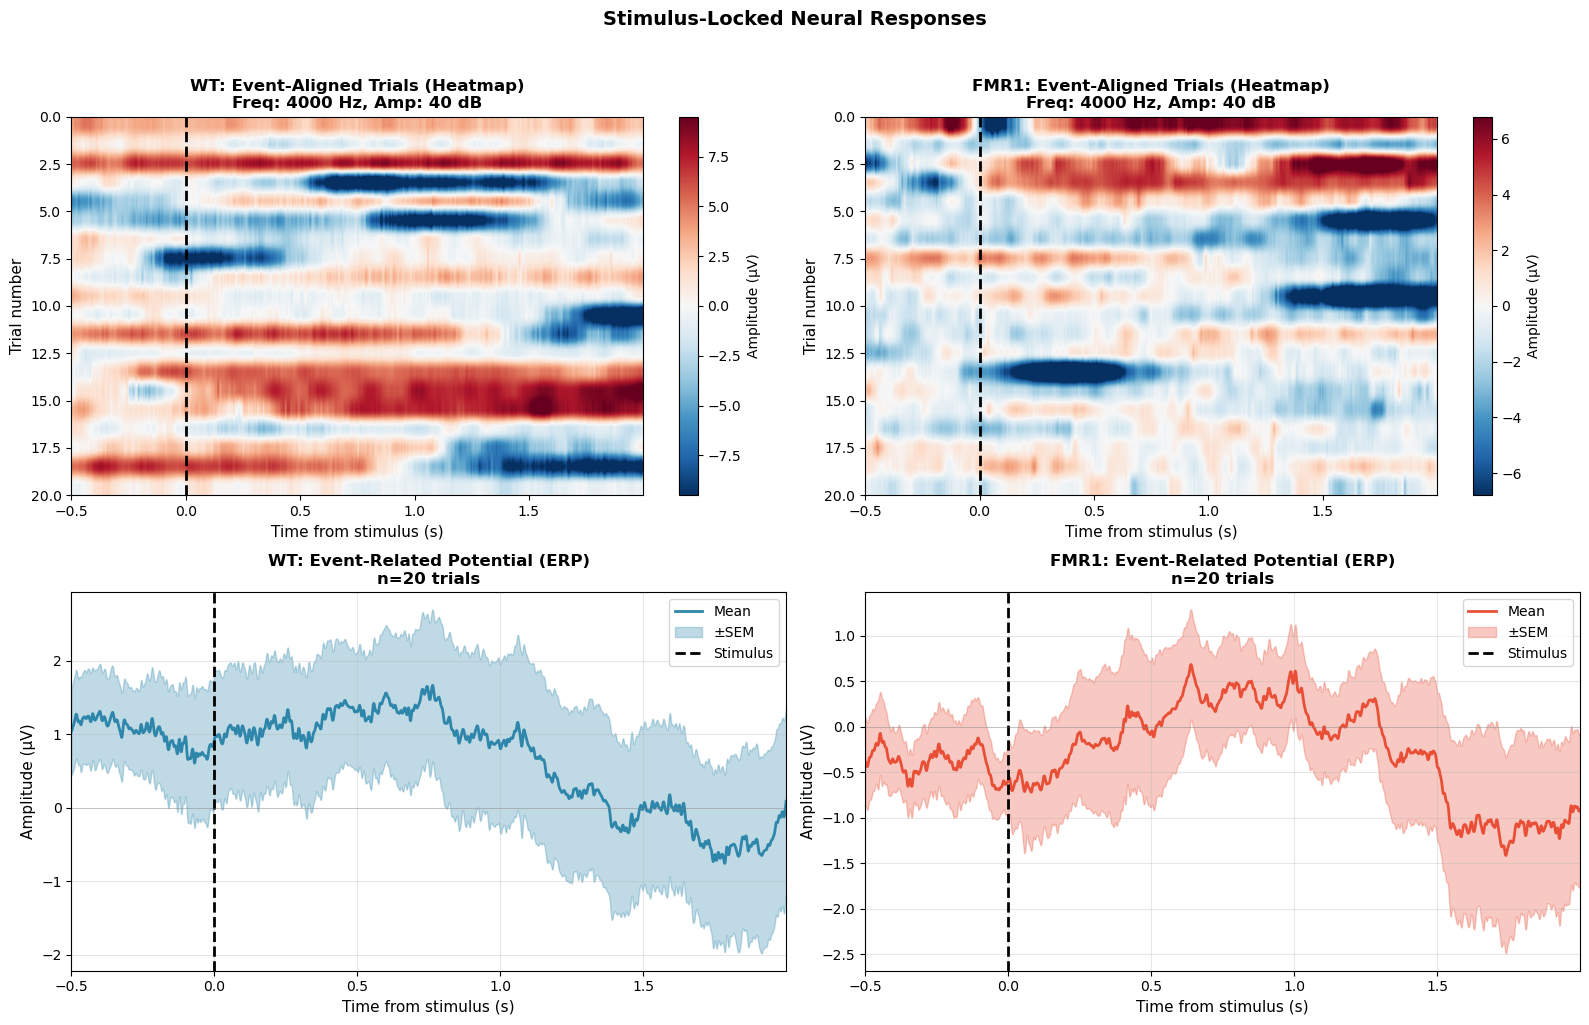

In [18]:
# Event-Aligned Plots: Stimulus-Locked Response
# Focus on window around stimulus onset

# Define event-aligned window (relative to stimulus onset)
PRE_STIMULUS = 0.5   # seconds before stimulus
POST_STIMULUS = 2.0  # seconds after stimulus
N_TRIALS_EVENT = 20  # Number of trials for averaging

# Calculate sample indices for the window
onset_sample = int(STIMULUS_ONSET * FS)
pre_samples = int(PRE_STIMULUS * FS)
post_samples = int(POST_STIMULUS * FS)

# Event-aligned time axis (relative to stimulus onset)
event_time = np.arange(-pre_samples, post_samples) / FS

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for col, condition in enumerate(['WT', 'FMR1']):
    condition_df = sample_data[sample_data['condition'] == condition]
    
    # Get most common frequency/amplitude combo
    freq_amp_counts = condition_df.groupby(['frequency', 'amplitude']).size()
    best_combo = freq_amp_counts.idxmax()
    
    subset = condition_df[
        (condition_df['frequency'] == best_combo[0]) & 
        (condition_df['amplitude'] == best_combo[1])
    ].head(N_TRIALS_EVENT)
    
    # Extract event-aligned segments
    aligned_traces = []
    for _, row in subset.iterrows():
        trace = parse_trace(row['trace'])
        start_idx = onset_sample - pre_samples
        end_idx = onset_sample + post_samples
        if end_idx <= len(trace):
            aligned_traces.append(trace[start_idx:end_idx])
    
    aligned_traces = np.array(aligned_traces)
    mean_trace = aligned_traces.mean(axis=0)
    std_trace = aligned_traces.std(axis=0)
    sem_trace = std_trace / np.sqrt(len(aligned_traces))
    
    # Top row: Individual trials heatmap
    ax_heat = axes[0, col]
    im = ax_heat.imshow(aligned_traces, aspect='auto', cmap='RdBu_r',
                        extent=[event_time[0], event_time[-1], len(aligned_traces), 0],
                        vmin=-np.percentile(np.abs(aligned_traces), 95),
                        vmax=np.percentile(np.abs(aligned_traces), 95))
    ax_heat.axvline(0, color='black', linestyle='--', linewidth=2, label='Stimulus')
    ax_heat.set_xlabel('Time from stimulus (s)', fontsize=11)
    ax_heat.set_ylabel('Trial number', fontsize=11)
    ax_heat.set_title(f'{condition}: Event-Aligned Trials (Heatmap)\n'
                      f'Freq: {best_combo[0]} Hz, Amp: {best_combo[1]} dB', 
                      fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax_heat, label='Amplitude (μV)')
    
    # Bottom row: Mean ± SEM
    ax_mean = axes[1, col]
    color = '#2E86AB' if condition == 'WT' else '#E94F37'
    ax_mean.plot(event_time, mean_trace, linewidth=2, color=color, label='Mean')
    ax_mean.fill_between(event_time, mean_trace - sem_trace, mean_trace + sem_trace,
                         alpha=0.3, color=color, label='±SEM')
    ax_mean.axvline(0, color='black', linestyle='--', linewidth=2, label='Stimulus')
    ax_mean.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax_mean.set_xlabel('Time from stimulus (s)', fontsize=11)
    ax_mean.set_ylabel('Amplitude (μV)', fontsize=11)
    ax_mean.set_title(f'{condition}: Event-Related Potential (ERP)\n'
                      f'n={len(aligned_traces)} trials', fontsize=12, fontweight='bold')
    ax_mean.legend(loc='upper right')
    ax_mean.grid(True, alpha=0.3)
    ax_mean.set_xlim([event_time[0], event_time[-1]])

plt.suptitle('Stimulus-Locked Neural Responses', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


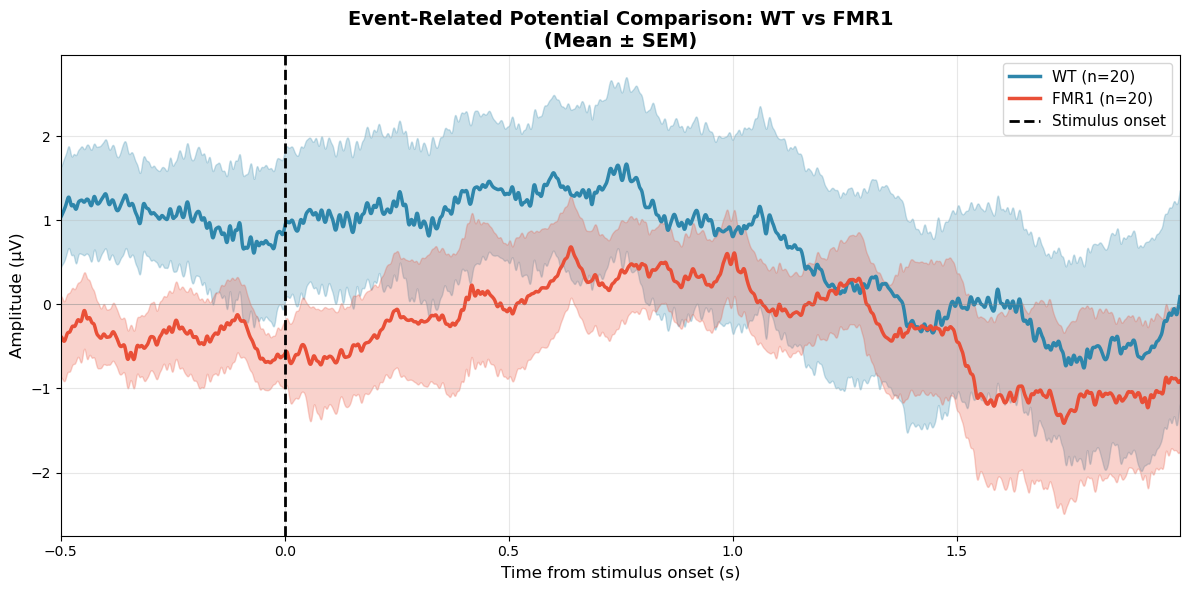


📊 ERP Summary Statistics:
--------------------------------------------------
WT:
   Stimulus: 4000 Hz @ 40 dB
   Peak amplitude (0-0.5s): 1.462 μV
   Peak latency: 457.0 ms
FMR1:
   Stimulus: 4000 Hz @ 40 dB
   Peak amplitude (0-0.5s): 0.719 μV
   Peak latency: 81.0 ms


In [19]:
# Direct ERP Comparison: WT vs FMR1 Overlaid
fig, ax = plt.subplots(figsize=(12, 6))

erp_data = {}
for condition in ['WT', 'FMR1']:
    condition_df = sample_data[sample_data['condition'] == condition]
    
    # Get most common frequency/amplitude combo
    freq_amp_counts = condition_df.groupby(['frequency', 'amplitude']).size()
    best_combo = freq_amp_counts.idxmax()
    
    subset = condition_df[
        (condition_df['frequency'] == best_combo[0]) & 
        (condition_df['amplitude'] == best_combo[1])
    ].head(N_TRIALS_EVENT)
    
    # Extract event-aligned segments
    aligned_traces = []
    for _, row in subset.iterrows():
        trace = parse_trace(row['trace'])
        start_idx = onset_sample - pre_samples
        end_idx = onset_sample + post_samples
        if end_idx <= len(trace):
            aligned_traces.append(trace[start_idx:end_idx])
    
    aligned_traces = np.array(aligned_traces)
    mean_trace = aligned_traces.mean(axis=0)
    sem_trace = aligned_traces.std(axis=0) / np.sqrt(len(aligned_traces))
    
    erp_data[condition] = {
        'mean': mean_trace,
        'sem': sem_trace,
        'n': len(aligned_traces),
        'freq': best_combo[0],
        'amp': best_combo[1]
    }

# Plot both conditions
colors = {'WT': '#2E86AB', 'FMR1': '#E94F37'}
for condition, data in erp_data.items():
    ax.plot(event_time, data['mean'], linewidth=2.5, color=colors[condition], 
            label=f"{condition} (n={data['n']})")
    ax.fill_between(event_time, 
                    data['mean'] - data['sem'], 
                    data['mean'] + data['sem'],
                    alpha=0.25, color=colors[condition])

ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Stimulus onset')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_xlabel('Time from stimulus onset (s)', fontsize=12)
ax.set_ylabel('Amplitude (μV)', fontsize=12)
ax.set_title('Event-Related Potential Comparison: WT vs FMR1\n(Mean ± SEM)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([event_time[0], event_time[-1]])

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 ERP Summary Statistics:")
print("-" * 50)
for condition, data in erp_data.items():
    # Peak response in post-stimulus window (0 to 0.5s after stimulus)
    post_stim_mask = (event_time >= 0) & (event_time <= 0.5)
    peak_amplitude = np.max(np.abs(data['mean'][post_stim_mask]))
    peak_latency = event_time[post_stim_mask][np.argmax(np.abs(data['mean'][post_stim_mask]))]
    
    print(f"{condition}:")
    print(f"   Stimulus: {data['freq']} Hz @ {data['amp']} dB")
    print(f"   Peak amplitude (0-0.5s): {peak_amplitude:.3f} μV")
    print(f"   Peak latency: {peak_latency*1000:.1f} ms")


In [25]:
len(sample_data["trace"][0])

5001